In [5]:
# coding:utf-8
# __author__ = 'huawang'
import random
import math

In [6]:
class Neuron:
    def __init__(self, bias):
        self.bias = bias
        self.weights = []

    def calculate_output(self, inputs):
        self.inputs = inputs
        self.output = self.squash(self.calculate_total_net_input())
        return self.output

    def calculate_total_net_input(self):
        total = 0
        for i in range(len(self.inputs)):
            total += self.inputs[i] * self.weights[i]
        return total + self.bias

    # 激活函数sigmoid
    def squash(self, total_net_input):
        return 1 / (1 + math.exp(-total_net_input))

    def calculate_pd_error_wrt_total_net_input(self, target_output):
        return self.calculate_pd_error_wrt_output(target_output) * self.calculate_pd_total_net_input_wrt_input()

    # 每一个神经元的误差是由平方差公式计算的
    def calculate_error(self, target_output):
        return 0.5 * (target_output - self.output) ** 2

    def calculate_pd_error_wrt_output(self, target_output):
        return -(target_output - self.output)

    def calculate_pd_total_net_input_wrt_input(self):
        return self.output * (1 - self.output)

    def calculate_pd_total_net_input_wrt_weight(self, index):
        return self.inputs[index]

In [7]:
class NeuronLayer:
    def __init__(self, num_neurons, bias):

        # 同一层的神经元共享一个截距项b
        self.bias = bias if bias else random.random()

        self.neurons = []
        for i in range(num_neurons):
            self.neurons.append(Neuron(self.bias))

    def inspect(self):
        print('Neurons:', len(self.neurons))
        for n in range(len(self.neurons)):
            print(' Neuron', n)
            for w in range(len(self.neurons[n].weights)):
                print('  Weight:', self.neurons[n].weights[w])
            print('  Bias:', self.bias)

    def feed_forward(self, inputs):
        outputs = []
        for neuron in self.neurons:
            outputs.append(neuron.calculate_output(inputs))
        return outputs

    def get_outputs(self):
        outputs = []
        for neuron in self.neurons:
            outputs.append(neuron.output)
        return outputs

In [8]:
class NeuralNetwork:
    LEARNING_RATE = 0.05

    def __init__(self, num_inputs, num_hidden, num_outputs, hidden_layer_weights=None, hidden_layer_bias=None,
                 output_layer_weights=None, output_layer_bias=None):
        self.num_inputs = num_inputs

        self.hidden_layer = NeuronLayer(num_hidden, hidden_layer_bias)
        self.output_layer = NeuronLayer(num_outputs, output_layer_bias)

        self.init_weights_from_inputs_to_hidden_layer_neurons(hidden_layer_weights)
        self.init_weights_from_hidden_layer_neurons_to_output_layer_neurons(output_layer_weights)

    def init_weights_from_inputs_to_hidden_layer_neurons(self, hidden_layer_weights):
        weight_num = 0
        for h in range(len(self.hidden_layer.neurons)):
            for i in range(self.num_inputs):
                if not hidden_layer_weights:
                    self.hidden_layer.neurons[h].weights.append(random.random())
                else:
                    self.hidden_layer.neurons[h].weights.append(hidden_layer_weights[weight_num])
                weight_num += 1

    def init_weights_from_hidden_layer_neurons_to_output_layer_neurons(self, output_layer_weights):
        weight_num = 0
        for o in range(len(self.output_layer.neurons)):
            for h in range(len(self.hidden_layer.neurons)):
                if not output_layer_weights:
                    self.output_layer.neurons[o].weights.append(random.random())
                else:
                    self.output_layer.neurons[o].weights.append(output_layer_weights[weight_num])
                weight_num += 1

    def inspect(self):
        print('------')
        print('* Inputs: {}'.format(self.num_inputs))
        print('------')
        print('Hidden Layer')
        self.hidden_layer.inspect()
        print('------')
        print('* Output Layer')
        self.output_layer.inspect()
        print('------')

    def feed_forward(self, inputs):
        hidden_layer_outputs = self.hidden_layer.feed_forward(inputs)
        return self.output_layer.feed_forward(hidden_layer_outputs)

    def train(self, training_inputs, training_outputs):
        self.feed_forward(training_inputs)

        # 1. 输出神经元的值
        pd_errors_wrt_output_neuron_total_net_input = [0] * len(self.output_layer.neurons)
        for o in range(len(self.output_layer.neurons)):
            # ∂E/∂zⱼ
            pd_errors_wrt_output_neuron_total_net_input[o] = self.output_layer.neurons[
                o].calculate_pd_error_wrt_total_net_input(training_outputs[o])

        # 2. 隐含层神经元的值
        pd_errors_wrt_hidden_neuron_total_net_input = [0] * len(self.hidden_layer.neurons)
        for h in range(len(self.hidden_layer.neurons)):

            # dE/dyⱼ = Σ ∂E/∂zⱼ * ∂z/∂yⱼ = Σ ∂E/∂zⱼ * wᵢⱼ
            d_error_wrt_hidden_neuron_output = 0
            for o in range(len(self.output_layer.neurons)):
                d_error_wrt_hidden_neuron_output += pd_errors_wrt_output_neuron_total_net_input[o] * \
                                                    self.output_layer.neurons[o].weights[h]

            # ∂E/∂zⱼ = dE/dyⱼ * ∂zⱼ/∂
            pd_errors_wrt_hidden_neuron_total_net_input[h] = d_error_wrt_hidden_neuron_output * \
                                                             self.hidden_layer.neurons[
                                                                 h].calculate_pd_total_net_input_wrt_input()

        # 3. 更新输出层权重系数
        for o in range(len(self.output_layer.neurons)):
            for w_ho in range(len(self.output_layer.neurons[o].weights)):
                # ∂Eⱼ/∂wᵢⱼ = ∂E/∂zⱼ * ∂zⱼ/∂wᵢⱼ
                pd_error_wrt_weight = pd_errors_wrt_output_neuron_total_net_input[o] * self.output_layer.neurons[
                    o].calculate_pd_total_net_input_wrt_weight(w_ho)

                # Δw = α * ∂Eⱼ/∂wᵢ
                self.output_layer.neurons[o].weights[w_ho] -= self.LEARNING_RATE * pd_error_wrt_weight

        # 4. 更新隐含层的权重系数
        for h in range(len(self.hidden_layer.neurons)):
            for w_ih in range(len(self.hidden_layer.neurons[h].weights)):
                # ∂Eⱼ/∂wᵢ = ∂E/∂zⱼ * ∂zⱼ/∂wᵢ
                pd_error_wrt_weight = pd_errors_wrt_hidden_neuron_total_net_input[h] * self.hidden_layer.neurons[
                    h].calculate_pd_total_net_input_wrt_weight(w_ih)

                # Δw = α * ∂Eⱼ/∂wᵢ
                self.hidden_layer.neurons[h].weights[w_ih] -= self.LEARNING_RATE * pd_error_wrt_weight

    def calculate_total_error(self, training_sets):
        total_error = 0
        for t in range(len(training_sets)):
            training_inputs, training_outputs = training_sets[t]
            self.feed_forward(training_inputs)
            for o in range(len(training_outputs)):
                total_error += self.output_layer.neurons[o].calculate_error(training_outputs[o])
        return total_error

    def predict(self, training_sets):
        predict = []
        for t in range(len(training_sets)):
            training_inputs, training_outputs = training_sets[t]
            self.feed_forward(training_inputs)
            p = []
            for o in range(len(training_outputs)):
                p.append(self.output_layer.neurons[o].output)
            predict.append([p, training_outputs])
        return predict

In [21]:
training_sets = [[0.05, 0.1], [0.01, 0.09]]
nn = NeuralNetwork(2, 2, 2, hidden_layer_weights=[0.15, 0.2, 0.25, 0.3], hidden_layer_bias=0.35,
                   output_layer_weights=[0.4, 0.45, 0.5, 0.55], output_layer_bias=0.6)

iter = []
loss = []
for i in range(100000):
    training_inputs, training_outputs = training_sets
    nn.train(training_inputs, training_outputs)
    ls = round(nn.calculate_total_error([[[0.05, 0.1], [0.01, 0.09]]]), 9)
    iter.append(i)
    loss.append(ls)

predict = nn.predict([training_sets])
print(predict)

[[[0.016017721308843526, 0.08997830804003706], [0.01, 0.09]]]


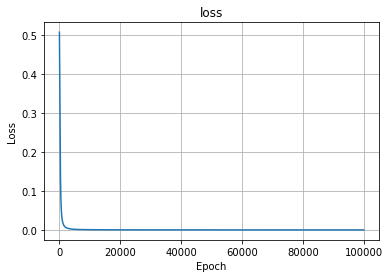

In [22]:
import matplotlib.pyplot as plt
plt.plot(iter,loss)
plt.grid(True) ##增加格点
plt.xlim(0,110000)
plt.ylim(0, 0.8)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('loss')
plt.axis('tight')
plt.show()

In [12]:
training_sets = [
    [[0, 0], [0]],
    [[0, 1], [1]],
    [[1, 0], [1]],
    [[1, 1], [0]]
]

nn = NeuralNetwork(len(training_sets[0][0]), 5, len(training_sets[0][1]))
iter = []
loss = []
for i in range(100000):
    training_inputs, training_outputs = random.choice(training_sets)
    nn.train(training_inputs, training_outputs)
    ls = nn.calculate_total_error(training_sets)
    iter.append(i)
    loss.append(ls)

predict = nn.predict(training_sets)
print(predict)

[[[0.07393974401208958], [0]], [[0.9434439048971232], [1]], [[0.9431168710699165], [1]], [[0.039003750298773926], [0]]]


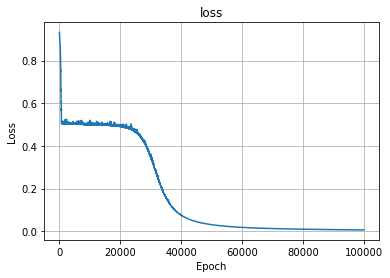

In [17]:
import matplotlib.pyplot as plt
plt.plot(iter,loss)
plt.grid(True) ##增加格点
plt.xlim(0,110000)
plt.ylim(0, 0.8)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('loss')
plt.axis('tight')
plt.show()